In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline


def normalize(array, maximum=None):
    if maximum is None:
        maximum = array.max()
    normalized = array / maximum
    return normalized


def get_coefs(target, real):
    return target[0] / real[0], target[1] / real[1], target[2] / real[2] 


def get_coefs_for_gray_world(avgs, avg_all):
    return avgs[0] / avg_all, avgs[1] / avg_all, avgs[2] / avg_all 



def correction_channel(channel, func):
    np_func = np.vectorize(func)
    channel = np_func(channel)
    return channel


def merge_normalized_channels(channels):
    theshold = np.vectorize(lambda x: min(1.0, x))
    new_image = []
    for c in channels:
#         channel = (theshold(c) * 255).astype('uint8')
        channel = (normalize(c) * 255).astype('uint8')
        new_image.append(c.astype('uint8'))
#         new_image.append(channel)
        
    return cv2.merge(new_image)


def split_to_normalized_channels(input_image):
    b, g, r = cv2.split(input_image)
    return b.astype('uint16'), g.astype('uint16'), r.astype('uint16')
#     return normalize(b, 255), normalize(g, 255), normalize(r, 255)


def color_correction_by_reference_color(image, target_color, selected_color):
    coefs = get_coefs(target_color, selected_color)
    
    b, g, r = split_to_normalized_channels(image)
    b = correction_channel(b, lambda x: x * coefs[0])
    g = correction_channel(g, lambda x: x * coefs[1])
    r = correction_channel(r, lambda x: x * coefs[2])

    corrected_image = merge_normalized_channels((b, g, r))
    return corrected_image


def color_correction_by_gray_world(image):
    b, g, r = cv2.split(original_image)
    
    avg_b = np.average(b)
    avg_g = np.average(g)
    avg_r = np.average(r)
    avg_all = (avg_b + avg_g + avg_r) / 3

    coefs = get_coefs_for_gray_world((avg_b, avg_g, avg_r), avg_all)
    
    b = correction_channel(b, lambda x: x * coefs[0])
    g = correction_channel(g, lambda x: x * coefs[1])
    r = correction_channel(r, lambda x: x * coefs[2])
    
    return merge_normalized_channels((b, g, r))
    
    
def color_correction_by_func(image, func):
    b, g, r = split_to_normalized_channels(image)
    b = correction_channel(b, func)
    g = correction_channel(g, func)
    r = correction_channel(r, func)

    corrected_image = merge_normalized_channels((b, g, r))
    return corrected_image


def color_correction_by_normalizing_hist(image):
    b, g, r = split_to_normalized_channels(image)

    b = normalize(b - b.min()) * 255
    g = normalize(g - g.min()) * 255
    r = normalize(r - r.min()) * 255

    corrected_image = merge_normalized_channels((b, g, r))
    return corrected_image


def color_correction_by_equalizing_histogram(image):
    h, s, l = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    l = equalize_channel(l)
    merged = np.dstack((h, s, l)).astype('uint8')
    corrected_image = cv2.cvtColor(merged, cv2.COLOR_HSV2BGR)
    return corrected_image


def get_histogram(image):
    pixels = list(image)
    histogram = [0 for i in range(256)]
    for pixel in pixels:
        histogram[int(pixel)] += 1
    return histogram


def plot_hist(hist, name, color):
    names = range(256)
    plt.bar(names, hist, color=color, width=1.0)
    plt.title(name)
    plt.show()
    
    
original_image = cv2.imread('mountain4.jpg')
destination_color = (160, 160, 160)
source_color = (100, 100, 100)

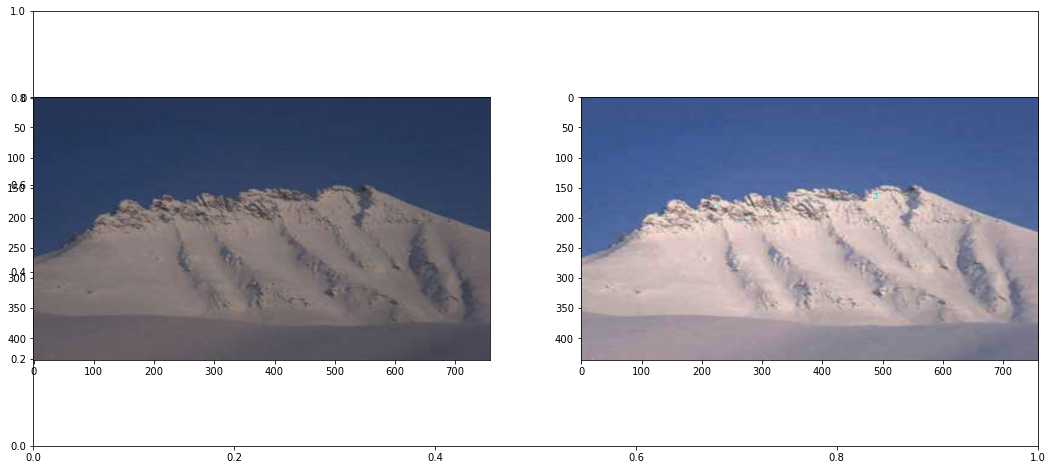

In [2]:
corrected_image = color_correction_by_reference_color(
    original_image, destination_color, source_color)
# corrected_image = image.copy()

fig, ax = plt.subplots(figsize=(18, 8))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))

plt.show()

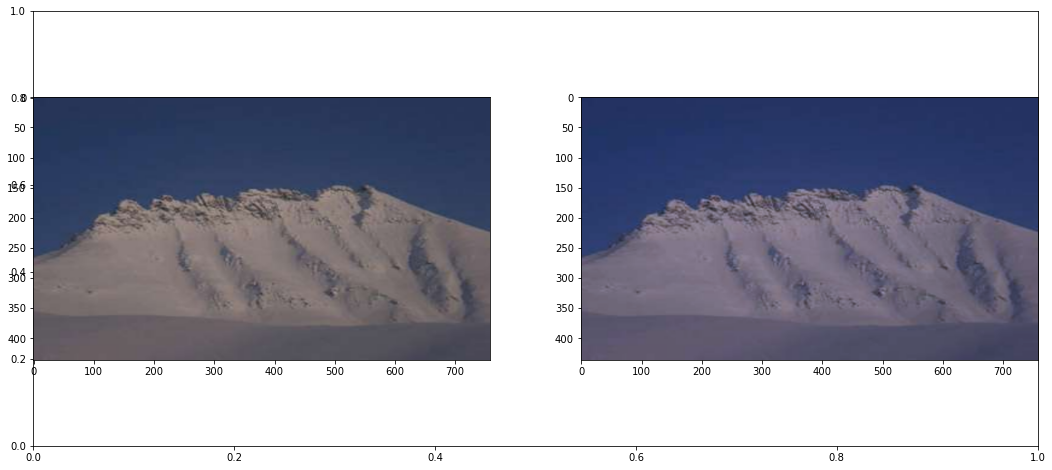

In [3]:
corrected_image = color_correction_by_gray_world(original_image)

fig, ax = plt.subplots(figsize=(18, 8))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))

plt.show()

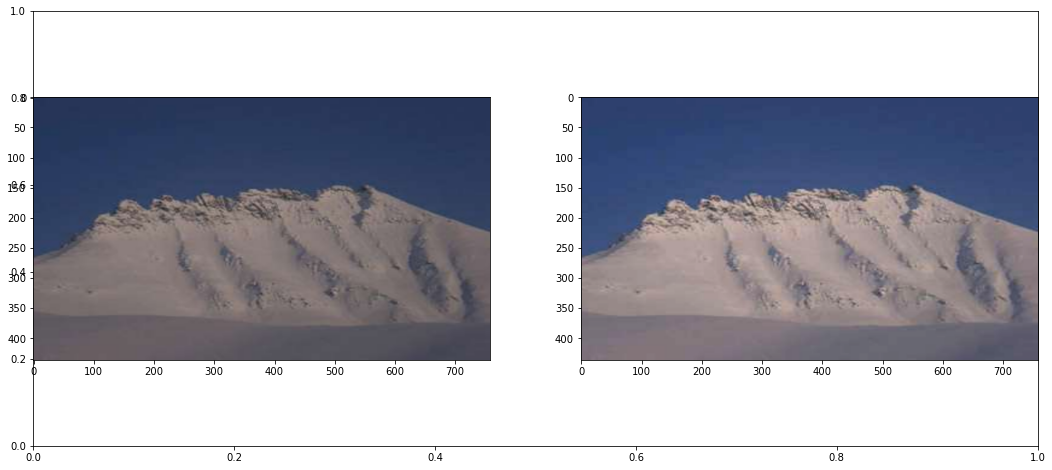

In [4]:
corrected_image = color_correction_by_func(original_image, lambda x: x**1.05)

fig, ax = plt.subplots(figsize=(18, 8))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))

plt.show()

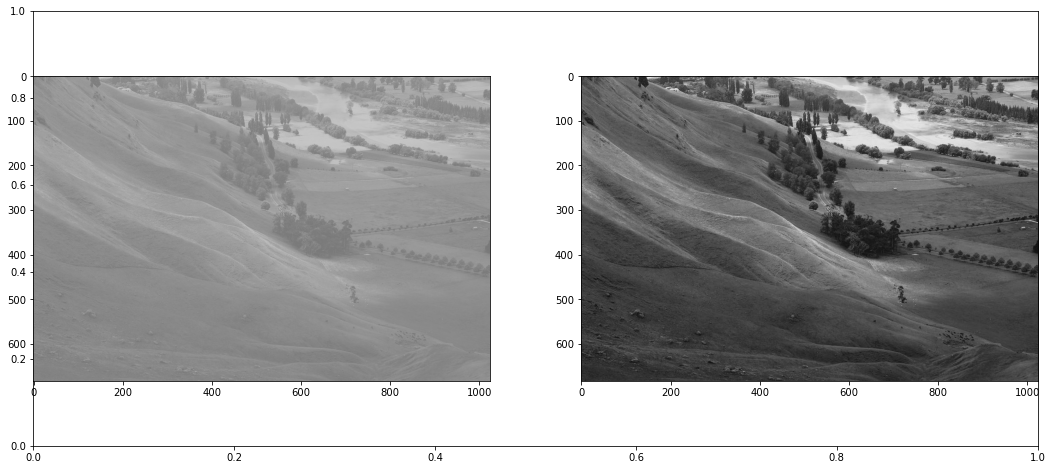

In [13]:
corrected_image = color_correction_by_normalizing_hist(original_image)

fig, ax = plt.subplots(figsize=(18, 8))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))

plt.show()

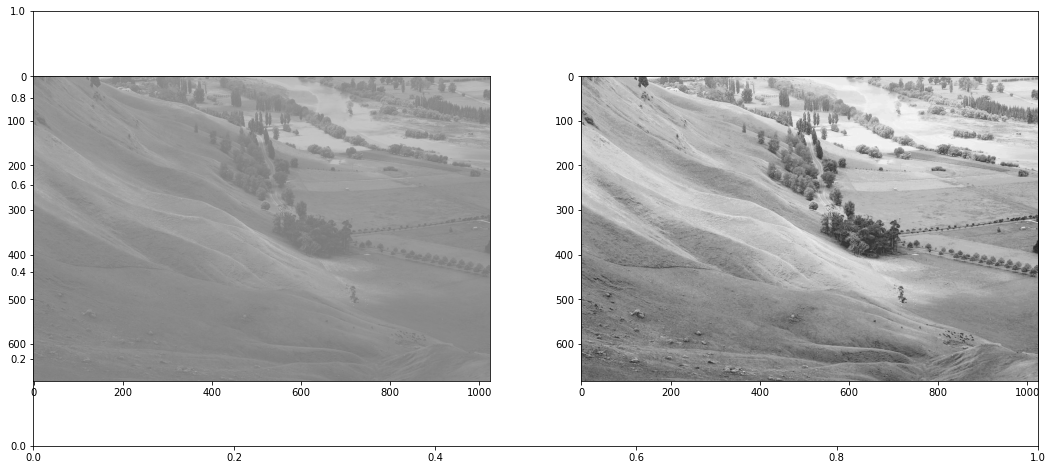

In [15]:
b, g, r = split_to_normalized_channels(original_image)

def equalize_channel(channel):
    gray_levels = 256
    pixel_count = len(channel) * len(channel[0])
    histogram, _ = np.histogram(channel, bins=gray_levels)
    
    acc = 0
    sdf = []
    for color in histogram:
        acc += color
        sdf.append(acc)

    sdf = np.array(sdf)
    
    def equalize(pixel, sdf, count):
        sdf_min = sdf.min()
        return round((sdf[pixel] - sdf_min) / (count - sdf_min) * (gray_levels - 1))

    equalize_histogram = np.vectorize(lambda x: equalize(x, sdf, pixel_count))
    channel = equalize_histogram(channel)
    return channel

    
# b = equalize_channel(b)
# g = equalize_channel(g)
# r = equalize_channel(r)

corrected_image = merge_normalized_channels((b, g, r))

fig, ax = plt.subplots(figsize=(18, 8))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(original_image, cmap='gray')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(equalize_channel(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)), cmap="gray")

plt.show()

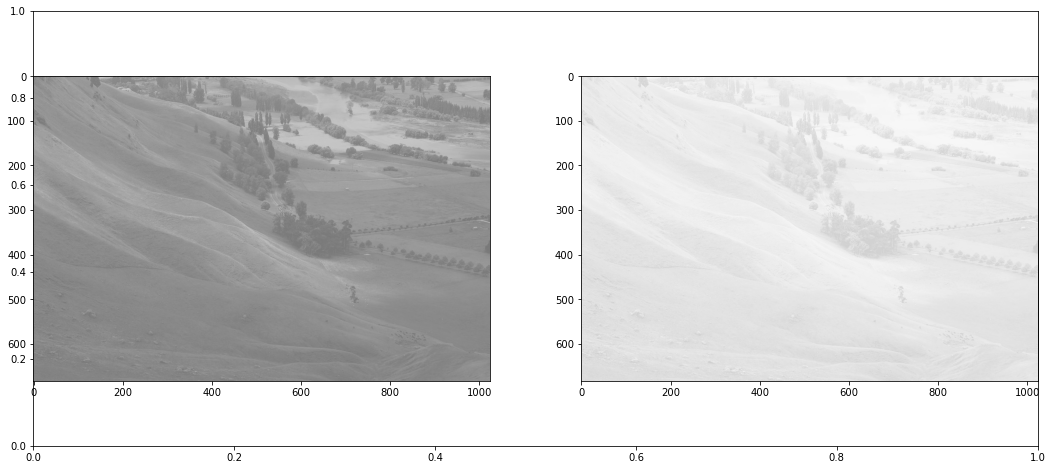

In [11]:
corrected_image = color_correction_by_equalizing_histogram(original_image)

fig, ax = plt.subplots(figsize=(18, 8))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))

plt.show()